In [3]:
import json
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from collections import Counter

In [4]:
from IPython.display import display
from IPython.display import set_matplotlib_formats
import matplotlib
pd.options.display.float_format = '{:,.2f}'.format
%config InlineBackend.figure_formats = ['svg']
plt.rc('axes', axisbelow=True)


### Loading the data 

In [5]:
data_partitions_dirpath = './data/random_split'
# code by Drew Bryant, one of the authors of the challenge and the paper :
# "Using deep learning to annotate the protein universe", Bileschi et. al. Nature (2022)
def read_all_shards(partition='dev', data_dir=data_partitions_dirpath):
    shards = []
    for fn in os.listdir(os.path.join(data_dir, partition)):
        with open(os.path.join(data_dir, partition, fn)) as f:
            shards.append(pd.read_csv(f, index_col=None))
    return pd.concat(shards)

test = read_all_shards('test')
dev = read_all_shards('dev')
train = read_all_shards('train')

test['seq_len'], dev['seq_len'], train['seq_len'] = test['sequence'].apply(len),  dev['sequence'].apply(len),  train['sequence'].apply(len)
partitions = {'test': test, 'dev': dev, 'train': train}
for name, df in partitions.items():
    print('Dataset partition "%s" has %d sequences' % (name, len(df)))
    
print('Fields contained in the dataset:',*train.columns, sep='\n')

Dataset partition "test" has 126171 sequences
Dataset partition "dev" has 126171 sequences
Dataset partition "train" has 1086741 sequences
Fields contained in the dataset:
family_id
sequence_name
family_accession
aligned_sequence
sequence
seq_len


In [6]:
train.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence,seq_len
0,Penicillinase_R,Q81U16_BACAN/8-123,PF03965.16,ISEAELEIMKVLWLKSP.QTANEIIEE.LEDP.MDW..KPKTIRTL...,ISEAELEIMKVLWLKSPQTANEIIEELEDPMDWKPKTIRTLINRLV...,116
1,Rtt106,POB3_CANAL/362-454,PF08512.12,AGVPCSVKA...SEGYLFPL......DRCFLF.VTKPTLYIPYSE....,AGVPCSVKASEGYLFPLDRCFLFVTKPTLYIPYSEISSVVMSRTGG...,93
2,F-actin_cap_A,Q8I3I2_PLAF7/12-301,PF01267.17,IRHVLMNSPPGKLYDLVK..DINILL.G.........SSVSIQ.KI...,IRHVLMNSPPGKLYDLVKDINILLGSSVSIQKILEEVLKDYNEKNY...,290
3,HupF_HypC,O28902_ARCFU/1-65,PF01455.18,MCIAIPGR...I.ER..IDY...............P....IAIVDF...,MCIAIPGRIERIDYPIAIVDFKGLKKEVRIDLLENPQIGDYVLVHV...,65
4,DUF3794,R6BY75_9CLOT/189-271,PF12673.7,NIFHI..LWEDVDL..E.GVTFKPMG...E...........S.......,NIFHILWEDVDLEGVTFKPMGESISVQGDIHIFVLYEGEGENTPIR...,83


### Data Analysis 

The goal of this step is to check the followings : 
- general statistics about the length of the sequence and the families of the domains
- the distribution of the lengths of the sequences in each partition of the dataset
- the distribution of the residues and confirm that 5 of them (X, U, B, O, Z) are not frequent at all
- class imbalance
- representation of the classes in all the partition of the dataset 

#### General Statistics : length of the sequence, families of the domains

`fam_*` statistics correspond to statistics on the number of sequences per family of the given partition.
`seq_len_*` statistics correspond to statistics on the lengths of the sequences of the given partition.  
`q25`, `q50`, and `q75`correspond respectively to the 1st quantile, the median and the 3rd quantile.

In [7]:
def analyse_dataset(partitions): 
    stats = dict()
    for name, df in partitions.items() : 
        fam_stats = df.groupby(by='family_accession').sequence_name.count()
        set_families_df = set(df.family_accession.values)
        stats[name] = {
            'nbr_samples': len(df),
            'nbr_fam': fam_stats.count().astype(int),
            'fam_in_df_and_in_train': len(set(partitions['train'].family_accession.values).intersection(set_families_df)),
            'fam_in_df_and_in_test': len(set(partitions['test'].family_accession.values).intersection(set_families_df)),
            'fam_in_df_and_in_dev': len(set(partitions['dev'].family_accession.values).intersection(set_families_df)),
            'fam_mean': fam_stats.mean().astype(int),
            'fam_min': fam_stats.min(),
            'fam_q25': fam_stats.quantile(q=0.25).astype(int),
            'fam_q50': fam_stats.quantile(q=0.5).astype(int),
            'fam_q75': fam_stats.quantile(q=0.75).astype(int),
            'fam_max': fam_stats.max(),
            'seq_len_mean': df.seq_len.mean().astype(int),
            'seq_len_min': df.seq_len.min(),
            'seq_len_q25': df.seq_len.quantile(q=0.25).astype(int),
            'seq_len_q50': df.seq_len.quantile(q=0.5).astype(int),
            'seq_len_q75': df.seq_len.quantile(q=0.75).astype(int),
            'seq_len_max': df.seq_len.max()
        }
    stats_df = pd.DataFrame(stats)
    return stats_df 

analyse_dataset(partitions)

,test,dev,train
nbr_samples,126171,126171,1086741
nbr_fam,13071,13071,17929
fam_in_df_and_in_train,13071,13071,17929
fam_in_df_and_in_test,13071,13071,13071
fam_in_df_and_in_dev,13071,13071,13071
fam_mean,9,9,60
fam_min,1,1,1
fam_q25,2,2,8
fam_q50,4,4,22
fam_q75,10,10,65


In [8]:
print('Are the families in the test set and the dev set equal?:', set(test['family_accession'].values) == set(dev['family_accession'].values))

Are the families in the test set and the dev set equal?: True


In [9]:
# Number of samples in the training set that belong to families that are absent from the dev and test sets : 
common_families = set(train.family_accession.unique()).intersection(set(test.family_accession.unique()))
len(train[~train['family_accession'].isin(common_families)]) / len(train)

0.02005169585025319

**Unrepresented families** It can be observed that 4858 domains' families from the training set are absent from both the dev and test sets. 
Samples belonging to those classes make up for 2% of the training set. Therefore we will not discard them as they can be helpful to the model to better represent the data and thus better classifiy the other classes. 


**Imbalance** It can also be observed that 50% of the families in the training set have less than 22 samples per family. With some that have only 1 sample and other with more than 3000 samples. There is an imbalance in the training set. Further analysis of that imbalance is performed below.

**Dev / test datasets** As a sanity check it can be seen that the test and dev tests do come from the same distribution and that the dataset is splitted in the usual fashion (i.e. 80/10/10 train/dev/test).

**Sequence length** It can be seen that on average the sequence have ~154 amino acids, at minimum 4 and at maximum over 2000. According to  "Favorable domain size in proteins", Xu et al. (1998), the lengths of chains of domains range from 50 to 200 amino acids. Extremely smaller lengths (e.g. 4) may thus be mistakes in the data since they may not fold due to a lack of inter-residue contacts. Very large chains may also be mistakes in the data as longer chains break into multiple domains. 


### Analysis of the sequences' lengths  

In [10]:
colors = {'test': 'green', 'dev': 'red', 'train': 'blue'}

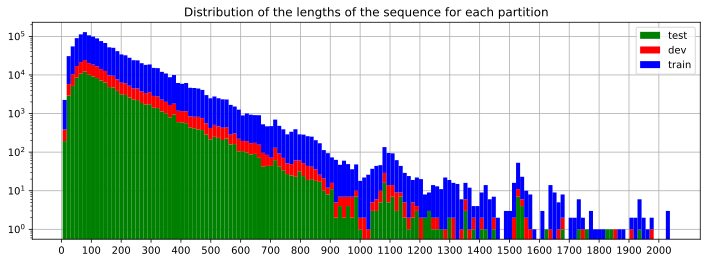

In [11]:
for name, df in partitions.items() : 
    df['seq_len']  = df['sequence'].apply(len)
    
plt.figure(figsize=(12, 4))
plt.yscale('log')
plt.xticks(ticks=np.arange(0,max([np.max(df['seq_len'].values) for df in partitions.values()]), 100))
plt.hist([df['seq_len'].values for df in partitions.values()], bins=150, histtype='barstacked', stacked=True, label=[*colors.keys()], color=colors.values())
plt.grid()
plt.legend(loc="upper right")
plt.title('Distribution of the lengths of the sequence for each partition')
plt.show()

### Analysis of the families of the domains

In [12]:
families_counts = dict()
for name, df in partitions.items() : 
    counts = df.groupby(by='family_accession').sequence_name.count().values
    families_counts[name] = counts

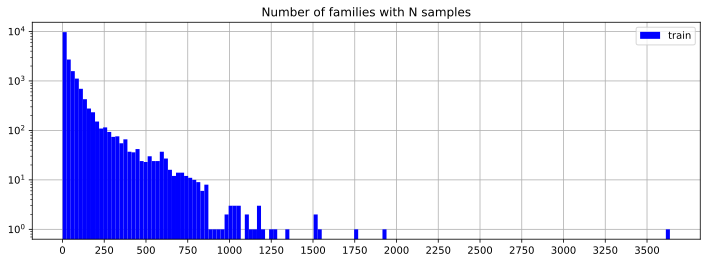

In [13]:
plt.figure(figsize=(12, 4))    
plt.yscale('log')
plt.xticks(ticks=np.arange(0,max(families_counts['train']), 250))
plt.hist(families_counts['train'], bins=150, histtype='bar', stacked=True, label='train', color=colors['train'])
plt.legend(loc="upper right")
plt.grid()
plt.title("Number of families with N samples")
plt.show()

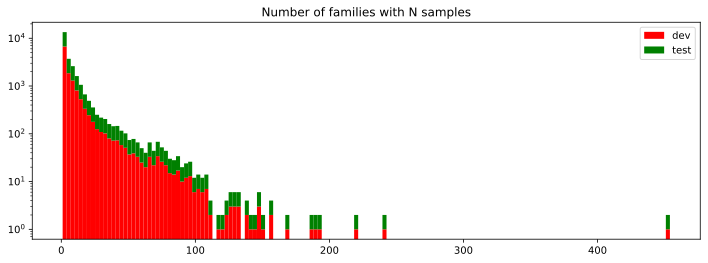

In [14]:
plt.figure(figsize=(12, 4))    
plt.yscale('log')
plt.hist([families_counts['dev'],families_counts['test']], bins=150, histtype='bar', stacked=True, label=['dev','test'], color=[colors['dev'],colors['test']])
plt.legend(loc="upper right")

plt.title('Number of families with N samples')
plt.show()

### Amino acids vocabulary 

As a sanity check, we compute the frequency of each amino acid in the sequences of each of the partition. 

In [15]:
def compute_AA_frequency(df): 
    AA_counter = dict(df['sequence'].apply(Counter).sum().most_common())
    return AA_counter 

# Compute counts of the AAs in the sequences of the training set
freq_train = compute_AA_frequency(train) 
# Compute the sum of the lenghts of the sequences of the training set to compute AA's frequencies
sum_seq_lengths_train = train['seq_len'].sum() 

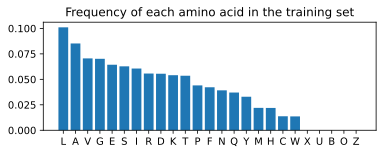

In [16]:
plt.figure(figsize=(6, 2))    
plt.bar(list(freq_train.keys()), list(freq_train.values())/sum_seq_lengths_train)
plt.title('Frequency of each amino acid in the training set')
plt.show()

X, U, B, O, Z amino acids are very uncommon and will later be processed differently at the preprocessing step as in "Using deep learning to annotate the protein universe", Bileschi et. al. Nature (2022). We will discard them from the sequence. In Bileshi et. al. they use vectors of 0's for those amino acid.

### Conclusion of the data analysis and practical considerations

Without further validation from biologists regarding the lengths of the sequences (and whether the too short or too large sequences are mistakes or not) and the absence of approximately 5000 families in the dev and test set (dev and test sets are usually supposed to represent the data on which we aim to use our model) we would conclude the following:
- the are no too small or too large domains in our data. 
- proteins on which we aim to use our model may include domains from the missing families and thus our model needs to be trained on them though it will not be evaluated on them.

Nonetheless, for time management and computational resources considerations (memory), the following choices will be made: 
- filter the dataset to keep only the `n_fam` (hyperparameter to be used depending on the memory ressources at disposal) most frequent families
- sequences of all lengths will be kept though we will implement the possibility to filter out some of them given a sequences' lengths range


The imbalance could be dealt with using for examples the following methods : 
- downsample the most present families 
- use weights to weight the loss given the amount of training data per class 
- use of Focal loss to help the model focus on samples it is not able to classify correctly 